In [1]:
import pandas as pd
import re
import json
import folium
import random
import numpy as np 

In [2]:
df = pd.read_pickle('Deals.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21552 entries, 0 to 21593
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   21552 non-null  object        
 1   Deal Owner Name      21523 non-null  object        
 2   Closing Date         14629 non-null  datetime64[ns]
 3   Quality              19308 non-null  object        
 4   Stage                21551 non-null  object        
 5   Lost Reason          16097 non-null  object        
 6   Page                 21551 non-null  object        
 7   Campaign             21552 non-null  object        
 8   SLA                  15515 non-null  object        
 9   Content              14122 non-null  object        
 10  Term                 12442 non-null  object        
 11  Source               21551 non-null  object        
 12  Payment Type         492 non-null    object        
 13  Product              3589 non-null  

In [4]:
df['Level of Deutsch'].unique()

array([nan, 'в1', 'A2', 'б1', 'b1', 'B1', 'в1-в2', 'B2', 'C2', 'с1', 'Б1',
       'а2', 'а1', 'а0', 'б2', 'Б2', 'В1', 'А2',
       'B1 будет в феврале 2025', 'Detmold, Paulinenstraße 95, 32756',
       'Сам оценивает на B2, 13 лет живет в Германии', 'в2', 'В1-В2',
       'Б1 ( ждет Б2)', 'А2-В1',
       'lэкзамен - 6 июля на В1. курсы вечером (но уверенно говорит на B1)',
       'Гражданка Германии уже год в Германии Учит немецкий и в сентябре b1 через гос-во проходит, а не через ДЖЦ, вечером учится 3 р в неделю с 18 до 21',
       '-', 'А2 ( Б1 в июне)', 'B1 в процессе обучения',
       'ЯЗ: нем В1 был экз 03.05 повтор и сейчас ждет результаты. Технический англ был. А1 сейчас. ОБР: 2 во информационные и комп сети - инженер системоте',
       'В1 в сентябре', 'Нет', 'С1', '0', 'Ждем B1',
       'А1 сертиф, но по факту А2', 'a2', 'Пока А2, сдает 17 05 B1',
       'окончание 13.06 курса на b1', 'A1', 'b2',
       'Thorn-Prikker-Str. 30, Hagen, 58093', 'В2',
       'нулевой уровень, тольк

In [ ]:
# Global log list
logs = []

# Define correct level order for comparison (for Latin and Cyrillic)
level_order = {
    'A1': 1, 'A2': 2, 'B1': 3, 'B2': 4, 'C1': 5, 'C2': 6,
    'А1': 1, 'А2': 2, 'В1': 3, 'В2': 4, 'С1': 5, 'С2': 6
}

# Create 'Parsed Level' column if it doesn't exist
if 'Parsed Level' not in df.columns:
    df['Parsed Level'] = None

# Function for basic language level parsing
def parse_level_basic(level):
    if isinstance(level, str):  # Check if value is a string
        match = re.fullmatch(r'[А-Яа-яA-Za-z][0-9]', level)  # Look for letter-number combination
        if match:
            return level.upper()  # If found, return value in uppercase
    return None  # If not a string or doesn't match format, return None

# Function to parse level with minimum value and city
def parse_level_and_city(level, city=None, row_index=None):
    global logs  # Use global log list for recording logs
    
    if isinstance(level, str):  # Check if value is a string
        
        # Look only for levels with letter and number in sequence (e.g., "B1", "A2", "В1", etc.)
        matches = re.findall(r'[A-Za-zА-Яа-я][0-9]', level)
        
        # If valid levels are found
        if matches:
            # Find minimum level based on order from level_order dictionary
            sorted_levels = sorted(matches, key=lambda x: level_order.get(x.upper(), float('inf')))
            min_level = sorted_levels[0].upper()
            logs.append(f"Original cell: '{level}'. Selected minimum level: {min_level} from {sorted_levels}.")
            return min_level
        
    return None

# Function for additional parsing based on conditions
def parse_additional_rules(row):
    original_value = row['Level of Deutsch']
    parsed_value = row['Parsed Level']
    
    # Check if value is a string before applying conditions
    if isinstance(original_value, str):
        # If cell already has a value, do not overwrite it
        if pd.notna(parsed_value):
            return row
        
        # Check conditions with "citizen", "lived in Germany for 25 years", etc.
        if any(phrase in original_value for phrase in [
            "citizen", "Citizen", "didn't take the test but is a citizen", 
            "didn't study (conversational), started working directly", 
            "lived in Germany for 25 years", "conversational from Ukraine, no certificate", 
            "unsure of level, but can speak - self-taught"
        ]):
            row['Parsed Level'] = 'B2'
            logs.append(f"Original cell: '{original_value}'. Assigned level: B2.")
        
        # Check conditions for individual letters with spaces, including 'Example with B1'
        elif re.fullmatch(r'\s*[BCA]\s*', original_value) or 'Example with B1' in original_value:
            level = 'B1' if 'B' in original_value else original_value.strip() + '1'
            row['Parsed Level'] = level
            logs.append(f"Original cell: '{original_value}'. Assigned level: {level}.")
        
        # Condition for 'By'
        elif 'By' in original_value:
            row['Parsed Level'] = 'B1'
            logs.append(f"Original cell: '{original_value}'. Assigned level: B1.")
    
    return row

# Function to handle special cases, like strings with letters at the start/end
def parse_special_cases(level):
    # Check if value is a string
    if isinstance(level, str):
        stripped_level = level.strip()

        # Check for exact match with 'B', 'A', 'C', 'B'
        if stripped_level in ['B', 'A', 'C']:
            return stripped_level + '1'

        # Check for 'B', 'A', 'C', 'B' at start or end of string
        if re.match(r'.*\b(B|A|C)\b.*', level):
            return re.search(r'\b(B|A|C)\b', level).group(1) + '1'

        # Search string for letter-number combinations like 'B1', 'C2', etc.
        match = re.search(r'[A-Za-zА-Яа-я][0-9]', stripped_level)
        if match:
            return match.group().upper()  # Return found value (e.g., 'B1' or 'C2')

    return None

# Apply all functions
for index, row in df.iterrows():
    if pd.isna(row['Parsed Level']):  # Apply only to rows where Parsed Level is empty
        df.at[index, 'Parsed Level'] = parse_level_basic(row['Level of Deutsch'])  # Basic parsing
        df.at[index, 'Parsed Level'] = parse_level_and_city(row['Level of Deutsch'], row['City'], index)  # Parsing with level and city

# Apply function based on additional conditions
df = df.apply(parse_additional_rules, axis=1)

# Apply parsing for special cases
df['Parsed Level'] = df['Level of Deutsch'].apply(parse_special_cases)

# Print rows that were modified
df.info()  # Display DataFrame information

# Print change logs
for log in logs:
    print(log)

<class 'pandas.core.frame.DataFrame'>
Index: 21552 entries, 0 to 21593
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   21552 non-null  object        
 1   Deal Owner Name      21523 non-null  object        
 2   Closing Date         14629 non-null  datetime64[ns]
 3   Quality              19308 non-null  object        
 4   Stage                21551 non-null  object        
 5   Lost Reason          16097 non-null  object        
 6   Page                 21551 non-null  object        
 7   Campaign             21552 non-null  object        
 8   SLA                  15515 non-null  object        
 9   Content              14122 non-null  object        
 10  Term                 12442 non-null  object        
 11  Source               21551 non-null  object        
 12  Payment Type         492 non-null    object        
 13  Product              3589 non-null  

In [ ]:
# List of phrases that should be replaced with 'B2' in 'Parsed Level'
phrases_to_replace = [
    "гражданка", "Гражданин", "25 лет живет в Германии", 
    "не сдавал, но гражданин", "не учила (разговорный) сразу пошла работать", 
    "Бй", "разговорный из Украины, без сертификата", 
    "точно уровень не знаю, но говорить могу - учила сама"
]

# Apply the replacement logic for rows where 'Parsed Level' is empty and matches with phrases
df['Parsed Level'] = df.apply(
    lambda row: 'B2' if (pd.isna(row['Parsed Level']) and isinstance(row['Level of Deutsch'], str) 
                         and any(phrase in row['Level of Deutsch'] for phrase in phrases_to_replace)) 
    else row['Parsed Level'], axis=1
)

In [ ]:
# Read the JSON file
with open('georef-germany-postleitzahl.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Convert JSON to DataFrame
geo_df = pd.json_normalize(data)

# View the first rows
geo_df.head()

,name,plz_name,plz_name_long,plz_code,krs_code,lan_name,lan_code,krs_name,geometry.type,geometry.geometry.coordinates,geometry.geometry.type,geo_point_2d.lon,geo_point_2d.lat
0,58099,Hagen,58099 Hagen,58099,05914,Nordrhein-Westfalen,05,Kreisfreie Stadt Hagen,Feature,"[[[7.4470632, 51.388113], [7.4516509, 51.39092...",Polygon,7.487858,51.400203
1,44534,Lünen,44534 Lünen,44534,05978,Nordrhein-Westfalen,05,Kreis Unna,Feature,"[[[7.4534471, 51.639174], [7.4535552, 51.63939...",Polygon,7.512674,51.631493
2,51645,Gummersbach,51645 Gummersbach,51645,05374,Nordrhein-Westfalen,05,Kreis Oberbergischer Kreis,Feature,"[[[7.4928902, 50.982133], [7.4928955, 50.98232...",Polygon,7.561839,50.998973
3,26489,Ochtersum,26489 Ochtersum,26489,03462,Niedersachsen,03,Landkreis Wittmund,Feature,"[[[7.4939875, 53.6097587], [7.4994004, 53.6158...",Polygon,7.525414,53.610278
4,44267,Dortmund,44267 Dortmund,44267,05913,Nordrhein-Westfalen,05,Kreisfreie Stadt Dortmund,Feature,"[[[7.4958702, 51.4612445], [7.4993758, 51.4615...",Polygon,7.524263,51.457949


In [ ]:
# Add new columns for country and geographic coordinates
df['Land'] = None
df['geo_point_lat'] = None
df['geo_point_lon'] = None

# Mapping matching cities
matching_cities_mapping = geo_df[['plz_name_long', 'lan_name', 'geo_point_2d.lon', 'geo_point_2d.lat']]

# Process rows with filled cities
df_filtered = df.dropna(subset=['City'])

# Fill data for matching cities
for city in df_filtered['City'].unique():
    geo_info = matching_cities_mapping[matching_cities_mapping['plz_name_long'].str.contains(city, case=False, regex=False)]
    
    if not geo_info.empty:
        # Extract latitude and longitude
        lat = geo_info['geo_point_2d.lat'].values[0]
        lon = geo_info['geo_point_2d.lon'].values[0]
        
        # Update data in the main dataframe
        df_filtered.loc[df_filtered['City'] == city, 'Land'] = geo_info['lan_name'].values[0]
        df_filtered.loc[df_filtered['City'] == city, 'geo_point_lat'] = lat
        df_filtered.loc[df_filtered['City'] == city, 'geo_point_lon'] = lon

# Return changes back to the main dataframe
df.update(df_filtered)

In [39]:
geo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8934 entries, 0 to 8933
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   name                           8934 non-null   object 
 1   plz_name                       8934 non-null   object 
 2   plz_name_long                  8934 non-null   object 
 3   plz_code                       8934 non-null   object 
 4   krs_code                       8934 non-null   object 
 5   lan_name                       8934 non-null   object 
 6   lan_code                       8934 non-null   object 
 7   krs_name                       8934 non-null   object 
 8   geometry.type                  8934 non-null   object 
 9   geometry.geometry.coordinates  8934 non-null   object 
 10  geometry.geometry.type         8934 non-null   object 
 11  geo_point_2d.lon               8934 non-null   float64
 12  geo_point_2d.lat               8934 non-null   f

In [ ]:
# Read the file with information about cities and federal states of Germany
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2510 entries, 56 to 21578
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Id                   2510 non-null   object        
 1   Deal Owner Name      2510 non-null   object        
 2   Closing Date         1237 non-null   datetime64[ns]
 3   Quality              2509 non-null   object        
 4   Stage                2510 non-null   object        
 5   Lost Reason          1306 non-null   object        
 6   Page                 2510 non-null   object        
 7   Campaign             2510 non-null   object        
 8   SLA                  2438 non-null   object        
 9   Content              1645 non-null   object        
 10  Term                 1420 non-null   object        
 11  Source               2510 non-null   object        
 12  Payment Type         420 non-null    object        
 13  Product              2458 non-null  

In [ ]:
# Filter data: deals where Stage = 'Payment Done' and Months of study > 0
df_filtered_deals = df[(df['Stage'] == 'Payment Done') & (df['Months of study'] > 0)]

# Prepare data for the map: cities and their coordinates
geo_distribution = df_filtered_deals.groupby(['City', 'geo_point_lat', 'geo_point_lon']).size().reset_index(name='Deal Count')

# Create a map centered in Germany
m = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

# Add markers to the map for each city
for _, row in geo_distribution.iterrows():
    # Check if coordinates exist and are not empty
    if pd.notnull(row['geo_point_lat']) and pd.notnull(row['geo_point_lon']):
        # Try to output the coordinates to ensure they exist
        print(f"City: {row['City']}, Lat: {row['geo_point_lat']}, Lon: {row['geo_point_lon']}, Deals: {row['Deal Count']}")
        
        folium.CircleMarker(
            location=[float(row['geo_point_lat']), float(row['geo_point_lon'])],
            radius=8,  # Make the markers larger
            popup=f"{row['City']}: {row['Deal Count']} deals",
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6  # Make them semi-transparent
        ).add_to(m)

# Save the map to a file
m.save('deal_distribution_map.html')

# Message for the user
print("The map has been saved as 'deal_distribution_map.html'. Open it in your browser.")

City: -, Lat: 50.9268852653, Lon: 6.10426703799, Deals: 60
City: Aachen, Lat: 50.7576280427, Lon: 6.10442503654, Deals: 2
City: Achberg, Lat: 47.6223698241, Lon: 9.71398197831, Deals: 1
City: Ahaus, Lat: 51.9826553192, Lon: 10.252335718, Deals: 1
City: Aichwald, Lat: 48.7628902603, Lon: 9.38755420777, Deals: 1
City: Albstadt, Lat: 48.1986061781, Lon: 9.0271089656, Deals: 1
City: Alfeld, Lat: 50.6130424899, Lon: 11.3013432749, Deals: 1
City: Altshausen, Lat: 47.936645706, Lon: 9.53092611333, Deals: 1
City: Altötting, Lat: 48.228018576, Lon: 12.6657939516, Deals: 1
City: Amberg, Lat: 49.8812007183, Lon: 10.9289759666, Deals: 1
City: Ansbach, Lat: 49.2860784141, Lon: 10.6542924608, Deals: 2
City: Apen, Lat: 52.3916575148, Lon: 7.48049802476, Deals: 1
City: Arnsberg, Lat: 51.4264729667, Lon: 7.93255675814, Deals: 2
City: Aschaffenburg, Lat: 49.9803769138, Lon: 9.11704621909, Deals: 2
City: Augsburg, Lat: 48.3614475786, Lon: 10.8654734233, Deals: 4
City: Bad Berleburg, Lat: 51.05506641, Lon

In [ ]:
# Open and load data from GeoJSON
with open('OSMB-0dd24f4686079255da57ccd8938de57dadde03f6.geojson', 'r', encoding='utf-8') as file:
    geo_data = json.load(file)

# Filter data: deals where Stage = 'Payment Done' and Months of study > 0
df_filtered_deals = df[(df['Stage'] == 'Payment Done') & (df['Months of study'] > 0)]

# Count the number of deals by land
deal_counts_by_land = df_filtered_deals.groupby('Land')['City'].count().reset_index()
deal_counts_by_land.rename(columns={'City': 'Deal Count'}, inplace=True)

# Create a map centered in Germany
m = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

# Add a choropleth layer (coloring the lands)
choropleth = folium.Choropleth(
    geo_data=geo_data,
    name="choropleth",
    data=deal_counts_by_land,
    columns=['Land', 'Deal Count'],
    key_on="feature.properties.name",  # Use the 'name' field from GeoJSON
    fill_color="YlOrRd",  # Change the palette to a more noticeable one
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Number of Deals by Land"
).add_to(m)

# Add popups with debugging data
folium.GeoJsonTooltip(
    fields=['name'],
    aliases=['Land Name:'],
    localize=True
).add_to(choropleth.geojson)

# Add layer control for popups with deal counts
folium.LayerControl().add_to(m)

# Save the map to an HTML file
m.save('choropleth_deals_by_land_map.html')

print("The map has been updated and saved as 'choropleth_deals_by_land_map.html'. Open it in your browser.")

Карта обновлена и сохранена как 'choropleth_deals_by_land_map.html'. Открой её в браузере.


In [ ]:
# Open and load data from GeoJSON
with open('OSMB-3bd6ab5e60caa734cb6d315896cf2281799ae6ee.geojson', 'r', encoding='utf-8') as file:
    geo_data = json.load(file)

# Filter data: deals where Stage = 'Payment Done' and Months of study > 0
df_filtered_deals = df[(df['Stage'] == 'Payment Done') & (df['Months of study'] > 0)]

# Count the number of deals by land
deal_counts_by_land = df_filtered_deals.groupby('Land')['City'].count().reset_index()
deal_counts_by_land.rename(columns={'City': 'Deal Count'}, inplace=True)

# Define bins for color scale
max_deals = deal_counts_by_land['Deal Count'].max()
bins = list(range(0, max_deals + 1, max(max_deals // 6, 1)))  # Divide data into 6 intervals

# Create a map centered in Germany
m = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

# Add a choropleth layer (coloring the lands)
choropleth = folium.Choropleth(
    geo_data=geo_data,
    name="choropleth",
    data=deal_counts_by_land,
    columns=['Land', 'Deal Count'],
    key_on="feature.properties.name",  # Use the 'name' field from GeoJSON
    fill_color="YlGnBu",  # Bright and contrasting color palette
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Number of Deals by Land",
    bins=bins,  # Add custom bins for the color map
    reset=True
).add_to(m)

# Add popups with land names
folium.GeoJsonTooltip(
    fields=['name'],
    aliases=['Land Name:'],
    localize=True
).add_to(choropleth.geojson)

# Add layer control for popups with deal counts
folium.LayerControl().add_to(m)

# Save the map to an HTML file
m.save('choropleth_deals_by_land_map.html')

print("The map has been updated and saved as 'choropleth_deals_by_land_map.html'. Open it in your browser.")

Карта обновлена и сохранена как 'choropleth_deals_by_land_map.html'. Открой её в браузере.


In [ ]:
# Count the number of clients by land, using 'Id' for unique deals
land_client_counts = df_filtered_deals.groupby('Land')['Id'].count().reset_index()
land_client_counts.rename(columns={'Id': 'Number of Clients'}, inplace=True)

# Display the table
land_client_counts

,Land,Number of Clients
0,Baden-Württemberg,93
1,Bayern,108
2,Berlin,79
3,Brandenburg,9
4,Bremen,6
5,Hamburg,22
6,Hessen,38
7,Mecklenburg-Vorpommern,9
8,Niedersachsen,62
9,Nordrhein-Westfalen,198


In [45]:
print(df_filtered_deals.columns)
print(df_filtered_deals[['Land', 'Offer Total Amount', 'Course duration', 'Months of study']].head())

Index(['Id', 'Deal Owner Name', 'Closing Date', 'Quality', 'Stage',
       'Lost Reason', 'Page', 'Campaign', 'SLA', 'Content', 'Term', 'Source',
       'Payment Type', 'Product', 'Education Type', 'Created Time',
       'Course duration', 'Months of study', 'Initial Amount Paid',
       'Offer Total Amount', 'Contact Name', 'City', 'Level of Deutsch',
       'Created Date', 'Parsed Level', 'Land', 'geo_point_lat',
       'geo_point_lon'],
      dtype='object')
                        Land  Offer Total Amount  Course duration  \
468                     None              4500.0             11.0   
478   Mecklenburg-Vorpommern              4500.0             11.0   
497            Niedersachsen              9000.0              6.0   
833                  Sachsen              9000.0              6.0   
1040       Baden-Württemberg             11000.0             11.0   

      Months of study  
468               1.0  
478               1.0  
497               1.0  
833               1.0  

In [ ]:
# Create a copy of df_filtered_deals to avoid SettingWithCopyWarning
df_filtered_deals = df[(df['Stage'] == 'Payment Done') & (df['Months of study'] > 0)].copy()

# Get unique names of German lands (Land), excluding empty values
german_lands = df_filtered_deals['Land'].dropna().unique()

# Function for randomly assigning a land for those without a land but have a city specified
def assign_random_land():
    return random.choice(german_lands)

# Assign random land for deals that have no land (only if a city is specified)
df_filtered_deals.loc[df_filtered_deals['Land'].isnull() & df_filtered_deals['City'].notnull(), 'Land'] = df_filtered_deals['City'].apply(lambda x: assign_random_land() if pd.isnull(x) else x)

# Add a column calculating profit for each deal
df_filtered_deals['Profit'] = round(df_filtered_deals['Offer Total Amount'] / df_filtered_deals['Course duration'] * df_filtered_deals['Months of study'], 2)

# Check total profit before grouping by lands
total_profit_before_grouping = df_filtered_deals['Profit'].sum().round(2)
print(f"Total profit before grouping: {total_profit_before_grouping}")

# Identify deals that are outside Germany (e.g., cities that do not have a corresponding land)
non_german_deals = df_filtered_deals[~df_filtered_deals['Land'].isin(german_lands)]

# Count profit for deals outside Germany (category "Others")
other_profit = non_german_deals['Profit'].sum().round(2)

# Count profit by each land (only for German lands)
land_profit = df_filtered_deals[df_filtered_deals['Land'].isin(german_lands)].groupby('Land')['Profit'].sum().reset_index()
land_profit.rename(columns={'Profit': 'Total Profit'}, inplace=True)

# Check if any data was lost during grouping
total_profit_after_grouping = land_profit['Total Profit'].sum().round(2)
print(f"Total profit after grouping (excluding Others): {total_profit_after_grouping}")

# Create a row for deals outside Germany
other_row = pd.DataFrame({'Land': ['Others'], 'Total Profit': [other_profit]})

# Combine with the main DataFrame
land_profit = pd.concat([land_profit, other_row], ignore_index=True)

# Sort from highest profit to lowest
land_profit = land_profit.sort_values(by='Total Profit', ascending=False)

# Calculate total profit for all deals (including deals outside Germany)
total_profit = round(df_filtered_deals['Profit'].sum(), 2)

# Output total profit
print(f"Total profit: {total_profit}")

# Output table with profit by land
land_profit

Общая прибыль до группировки: 3340287.92
Общая прибыль после группировки (без Другие): 2849906.1
Общая прибыль: 3340287.92


,Land,Total Profit
9,Nordrhein-Westfalen,869287.91
16,Другие,490381.82
2,Berlin,371096.98
1,Bayern,345028.79
0,Baden-Württemberg,329350.00
8,Niedersachsen,224215.18
12,Sachsen,181260.59
6,Hessen,147462.12
5,Hamburg,81501.52
10,Rheinland-Pfalz,69409.07


In [ ]:
# Calculate the maximum and minimum profit values for proper bin creation
min_profit = land_profit['Total Profit'].min()
max_profit = land_profit['Total Profit'].max()

# Calculate boundaries for bins
bins = list(np.linspace(min_profit, max_profit, 7))  # Divide into 6 intervals

# Create a map centered in Germany
m = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

# Add a choropleth layer (coloring the lands) by profit
choropleth = folium.Choropleth(
    geo_data=geo_data,
    name="choropleth",
    data=land_profit,
    columns=['Land', 'Total Profit'],
    key_on="feature.properties.name",  # Use the 'name' field from GeoJSON
    fill_color="YlGnBu",  # Color palette
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Profit by Land",
    bins=bins,  # Boundaries for the color map
    reset=True
).add_to(m)

# Add tooltips with land names
folium.GeoJsonTooltip(
    fields=['name'],
    aliases=['Land Name:'],
    localize=True
).add_to(choropleth.geojson)

# Visualize profits in the "Others" category
folium.GeoJson(
    geo_data,  # here we should use GeoJSON for surrounding lands (outside of Germany)
    style_function=lambda feature: {
        'fillColor': '#808080',  # Gray fill for other lands
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.4,
    },
    name="Others"
).add_to(m)

# Save the map
m.save('choropleth_profit_by_land_with_others.html')

print("The map has been updated and saved as 'choropleth_profit_by_land_with_others.html'.")

Карта обновлена и сохранена как 'choropleth_profit_by_land_with_others.html'.


In [ ]:
# Create a map centered in Germany
m = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

# Determine the maximum profit for radius adjustment
max_profit = df_filtered_deals['Profit'].max()

# Filter out rows with empty coordinates
df_filtered_deals = df_filtered_deals.dropna(subset=['geo_point_lat', 'geo_point_lon'])

# Add markers for each city
for _, row in df_filtered_deals.iterrows():
    radius = row['Profit'] / max_profit * 10  # The higher the profit, the larger the circle
    
    # Generate color with a gradient from red to dark red
    red_intensity = int((1 - row["Profit"] / max_profit) * 255)
    color = f'#{red_intensity:02x}0000'  # The higher the profit, the darker the color

    # Add a marker for each city
    folium.CircleMarker(
        location=[row['geo_point_lat'], row['geo_point_lon']],  # City coordinates
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=f"City: {row['City']}, Profit: {row['Profit']}"
    ).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Save the map to an HTML file
m.save('profit_by_city_map_filtered.html')

print("The map has been updated and saved as 'profit_by_city_map_filtered.html'. Open it in your browser.")


Карта обновлена и сохранена как 'profit_by_city_map_filtered.html'. Открой её в браузере.


In [ ]:
import folium

# Create a map centered in Germany
m = folium.Map(location=[51.1657, 10.4515], zoom_start=6)

# Determine the maximum profit for circle radius adjustment
max_profit = land_profit['Total Profit'].max()

# Determine the maximum number of clients for circle radius adjustment
max_clients = df_filtered_deals['Number of Clients'].max()

# Filter out rows with empty coordinates
df_filtered_deals = df_filtered_deals.dropna(subset=['geo_point_lat', 'geo_point_lon'])

# Add a choropleth layer for lands (in blue color)
choropleth = folium.Choropleth(
    geo_data=geo_data,
    name="choropleth",
    data=land_profit,
    columns=['Land', 'Total Profit'],
    key_on="feature.properties.name",  # Use the 'name' field from GeoJSON
    fill_color="BuGn",  # Color palette in shades of blue
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Profit by Land",
    bins=bins,  # Boundaries for the color map
    reset=True
).add_to(m)

# Add markers for each city (in orange color) on top of the choropleth map
for _, row in df_filtered_deals.iterrows():
    radius = (row['Number of Clients'] / max_clients) * 15  # Increase radius for better visibility
    color = 'orange'  # Color of the circles

    # Add a marker for each city
    folium.CircleMarker(
        location=[row['geo_point_lat'], row['geo_point_lon']],  # City coordinates
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        popup=f"City: {row['City']}, Number of Clients: {row['Number of Clients']}"
    ).add_to(m)

# Add popups with land names
folium.GeoJsonTooltip(
    fields=['name'],
    aliases=['Land Name:'],
    localize=True
).add_to(choropleth.geojson)

# Add layer control
folium.LayerControl().add_to(m)

# Add a legend for the number of clients (in the top right corner, next to the profit legend)
legend_html_clients = '''
     <div style="position: fixed; 
     top: 50px; right: 50px; width: 150px; height: 90px; 
     background-color: white; z-index:9999; font-size:14px;
     ">&nbsp; <b>Number of Clients</b> <br>
     &nbsp; Large circle: More clients <br>
     &nbsp; Small circle: Fewer clients
     </div>
     '''
m.get_root().html.add_child(folium.Element(legend_html_clients))

# Save the map to an HTML file
m.save('clients_profit_map_with_layers.html')

print("The map has been updated and saved as 'clients_profit_map_with_layers.html'. Open it in your browser.")


Карта обновлена и сохранена как 'clients_profit_map_with_layers.html'. Открой её в браузере.


## Conclusions
Number of Deals:

The map showing the number of clients reveals that the main clusters of deals are concentrated in regions such as Nordrhein-Westfalen, Bayern, Berlin, and Baden-Württemberg.
The highest number of deals is recorded in Nordrhein-Westfalen (198 clients), which is confirmed by both the table and the visualization.
The lowest number of clients is registered in regions like Saarland (4 clients), Thüringen (6 clients), and Bremen (6 clients).
Profit by Region:

The profit distribution map indicates that Nordrhein-Westfalen also leads in total profit (€869,287.91), followed by Berlin (€371,096.98) and Bayern (€345,028.79).
The lowest profits are recorded in Saarland, Thüringen, Bremen, and Schleswig-Holstein.
Comparison of Profit and Number of Deals:

Nordrhein-Westfalen leads in both the number of deals and profit, indicating high activity and effectiveness of deals in this region.
Berlin and Bayern also show high figures for both criteria.
Regions with a low number of clients, such as Saarland, Thüringen, and Bremen, have correspondingly low profits as well.
Geographical Distribution:

The city map illustrates that the main clusters of deals are centered around major cities in the western and southern parts of Germany, such as Düsseldorf, Frankfurt, and Munich.
Northern and eastern regions, such as Schleswig-Holstein and Mecklenburg-Vorpommern, have fewer clients and deals, which is also reflected in the profit and quantity maps.
Recommendations:

Focus on Regions with High Activity: Regions like Nordrhein-Westfalen, Berlin, and Bayern could be key areas for further marketing and operational efforts.
Pay Attention to Less Active Regions: It may be worthwhile to reconsider strategies in regions like Saarland and Thüringen to increase activity and profit.

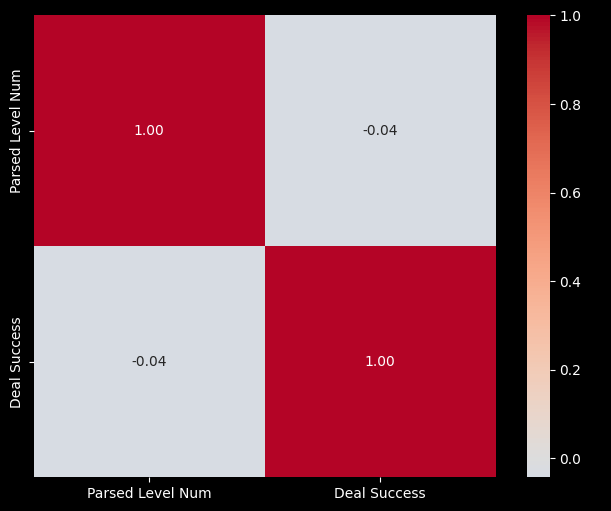

In [ ]:
# Create a mapping for German language levels
level_mapping = {
    'A1': 1,
    'A2': 2,
    'B1': 3,
    'B2': 4,
    'C1': 5,
    'C2': 6
}

# Convert 'Parsed Level' to numerical format
df['Parsed Level Num'] = df['Parsed Level'].map(level_mapping)

# Convert deal success to binary format
df['Deal Success'] = df['Stage'].apply(lambda x: 1 if x == 'Payment Done' else 0)

# Filter data for analysis only for rows where language levels are specified
df_filtered = df.dropna(subset=['Parsed Level Num', 'Deal Success'])

# Calculate the correlation matrix
corr_matrix = df_filtered[['Parsed Level Num', 'Deal Success']].corr()

# Set background, text color, and display heatmap
plt.figure(figsize=(8, 6), facecolor='black')  # Set black background for the figure
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt=".2f", cbar_kws={'label': 'Correlation'})

# Change the background color of the map
heatmap.set_facecolor('black')

# Set white color for axes and titles
heatmap.xaxis.label.set_color('white')
heatmap.yaxis.label.set_color('white')
heatmap.tick_params(colors='white')

# Change the color of values on the legend
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(colorbar.ax.axes, 'yticklabels'), color='white')

# Display the heatmap
plt.show()

## Conclusions
The correlation matrix shows that there is a weak negative correlation (-0.042729) between language proficiency level (Parsed Level Num) and deal success (Deal Success), indicating that the level of language knowledge does not significantly influence the success of deals. This may suggest that increasing language proficiency is not a key factor for the success of deals in the analyzed data. Therefore, it is advisable to consider other potential factors influencing deal success and to explore the application of more sophisticated analysis methods, such as regression analysis, to identify factors that contribute more significantly to the outcomes.